**Roseman Sales Dataset** - This dataset is a live dataset of Roseman Stores. On analsysing this problem we observe that Roseman problem is a regression problem and our primarily goal is to predict the sales figures of Roseman problem. In this Notebook we work on following topics
1. Analysing the Dataset by using Exploratory Data Analysis.
2. Using Exponential Moving Averages analyse Trends and Seasonality in Roseman dataset.
3. Analyse Regression analysis using following prediction analysis,
   A. Linear Regression Analysis
   B. Elastic Regression ( Lasso and Ridge Regression).
   C. Random Forest Regression.
   D. Extreme Gradiant Boosting Algorithm.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from fbprophet import Prophet

In [3]:
train_data = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')
train_data.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
train_data['Date'] = pd.to_datetime(train_data['Date'])

In [4]:
test_data = pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv')
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [8]:
test_data['Date'] = pd.to_datetime(test_data['Date'])

In [5]:
stores = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
train_data.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1


In [11]:
sales_df = train_data.rename(columns={'Date': 'ds', 'Sales': 'y'})[['ds', 'y']]

In [12]:
sales_df.head(2)

,ds,y
0,2015-07-31,5263
1,2015-07-31,6064


In [35]:
school_holidays_dates = train_data.loc[train_data.SchoolHoliday == 1, 'Date']
state_holidays_dates = train_data.loc[~train_data.StateHoliday.isin([0, '0']), 'Date']

In [36]:
school_holidays_dates.head()

0   2015-07-31
1   2015-07-31
2   2015-07-31
3   2015-07-31
4   2015-07-31
Name: Date, dtype: datetime64[ns]

In [37]:
state_holidays_dates.head()

63555   2015-06-04
63557   2015-06-04
63559   2015-06-04
63560   2015-06-04
63563   2015-06-04
Name: Date, dtype: datetime64[ns]

In [38]:
school_holidays_dates = pd.DataFrame(school_holidays_dates)
school_holidays_dates['holiday'] = 'school_holiday'

state_holidays_dates = pd.DataFrame(state_holidays_dates)
state_holidays_dates['holiday'] = 'state_holiday'

In [39]:
school_holidays_dates.head(3)

,Date,holiday
0,2015-07-31,school_holiday
1,2015-07-31,school_holiday
2,2015-07-31,school_holiday


In [40]:
state_holidays_dates.head(3)

,Date,holiday
63555,2015-06-04,state_holiday
63557,2015-06-04,state_holiday
63559,2015-06-04,state_holiday


In [43]:
holidays = pd.concat((state_holidays_dates, school_holidays_dates), ignore_index=True).rename(columns={'Date': 'ds'}).sort_values('ds').reset_index(drop=True)

In [44]:
holidays.head()

,ds,holiday
0,2013-01-01,school_holiday
1,2013-01-01,state_holiday
2,2013-01-01,state_holiday
3,2013-01-01,state_holiday
4,2013-01-01,state_holiday


In [45]:
my_model = Prophet(interval_width = 0.95, holidays = holidays)
my_model.fit(sales_df)

In [46]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [47]:
test_data.Date.agg({min, max})

max   2015-09-17
min   2015-08-01
Name: Date, dtype: datetime64[ns]

In [48]:
qty_weeks = len(pd.date_range(start=test_data.Date.min(), end=test_data.Date.max(), freq='W'))
qty_weeks

7

In [52]:
future_dates = pd.DataFrame(test_data.rename(columns={'Date': 'ds'})['ds'], columns=['ds'])

In [53]:
future_dates.head()

,ds
0,2015-09-17
1,2015-09-17
2,2015-09-17
3,2015-09-17
4,2015-09-17


In [54]:
test_forecast = my_model.predict(future_dates)

In [55]:
test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-08-01,5709.789443,406.427123,11618.500679,5709.789443,5709.789443,98.422517,98.422517,98.422517,0.0,...,47.500407,47.500407,47.500407,50.92211,50.92211,50.92211,0.0,0.0,0.0,5808.21196
1,2015-08-01,5709.789443,32.027533,11319.822007,5709.789443,5709.789443,98.422517,98.422517,98.422517,0.0,...,47.500407,47.500407,47.500407,50.92211,50.92211,50.92211,0.0,0.0,0.0,5808.21196
2,2015-08-01,5709.789443,445.881735,11833.373194,5709.789443,5709.789443,98.422517,98.422517,98.422517,0.0,...,47.500407,47.500407,47.500407,50.92211,50.92211,50.92211,0.0,0.0,0.0,5808.21196
3,2015-08-01,5709.789443,192.197350,11639.158641,5709.789443,5709.789443,98.422517,98.422517,98.422517,0.0,...,47.500407,47.500407,47.500407,50.92211,50.92211,50.92211,0.0,0.0,0.0,5808.21196
4,2015-08-01,5709.789443,578.153163,11379.635335,5709.789443,5709.789443,98.422517,98.422517,98.422517,0.0,...,47.500407,47.500407,47.500407,50.92211,50.92211,50.92211,0.0,0.0,0.0,5808.21196


In [56]:
test_forecast.to_csv('test_forecast_fbprophet.csv', index=False)

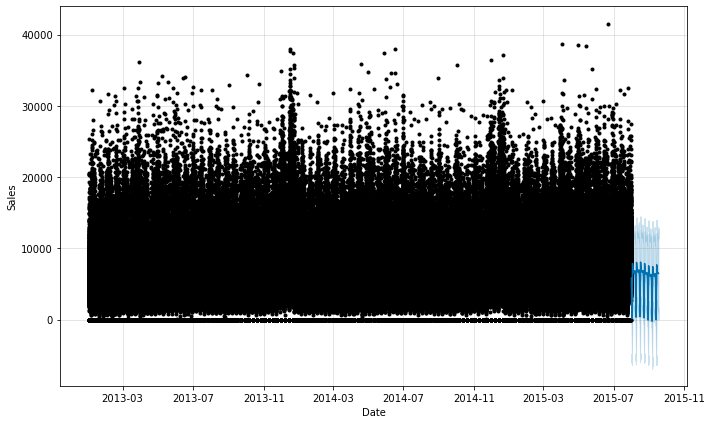

In [65]:
figure  = my_model.plot(test_forecast, xlabel='Date', ylabel='Sales')

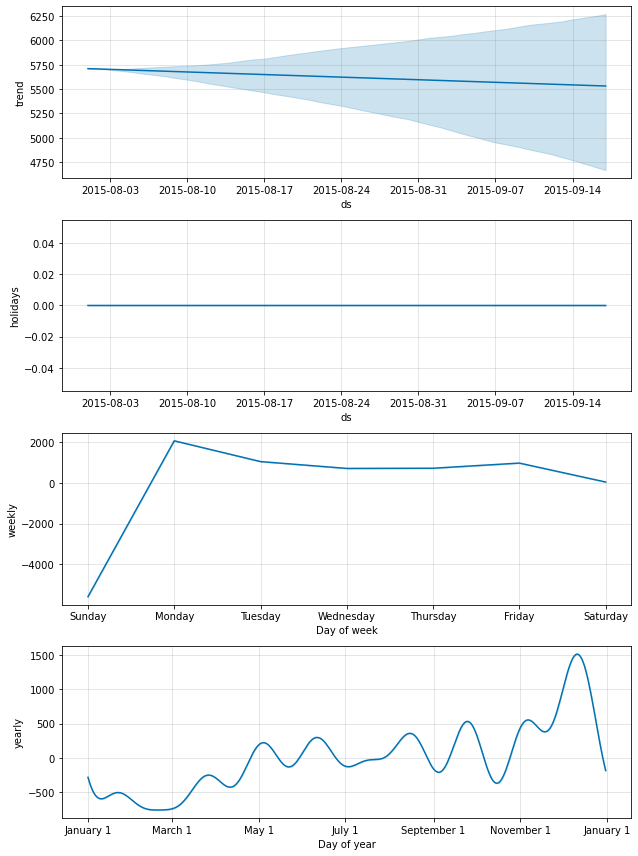

In [60]:
figure2  = my_model.plot_components(test_forecast)